In [1]:
import os
import json
import builtins

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageDraw

from tqdm.notebook import tqdm

import pickle

from sklearn.model_selection import StratifiedKFold

import torch
from datasets import load_from_disk
from transformers import (
    SegformerForSemanticSegmentation,
    SegformerFeatureExtractor,
    logging,
)


Some functions are not fully parametrized, and they exist in separate modules.

Global variables would not work. Builtins are used instead for the variables that need to be passed to some functions.

The whole code needs to be completely parametrized to get rid of builtins.

In [2]:
# the pretrained model used here
builtins.model_name = "mit-b5"
builtins.model_name_full = "nvidia/" + model_name
# the input image size for the pretrained model
builtins.image_size = (512, 512)
# choose batch size based on memory requirements for the model
builtins.model_batch_size = 6
# number of epochs used for training
num_epochs = 100

"""
# the pretrained model used here
builtins.model_name = "mit-b4"
builtins.model_name_full = "nvidia/" + model_name
# the input image size for the pretrained model
builtins.image_size = (512, 512)
# choose batch size based on memory requirements for the model
builtins.model_batch_size = 6
# number of epochs used for training
num_epochs = 100
"""

"""
# the pretrained model used here
builtins.model_name = "mit-b3"
builtins.model_name_full = "nvidia/" + model_name
# the input image size for the pretrained model
builtins.image_size = (512, 512)
# choose batch size based on memory requirements for the model
builtins.model_batch_size = 8
# number of epochs used for training
num_epochs = 100
"""

# folder containing the main dataset in HuggingFace format
train_dataset_path = "bus_4in1_datasets_single_class_" + str(image_size[0])

# folder containing all baseline model artifacts
baseline_dir = "model_baseline_" + model_name

model_dir = baseline_dir + "/models"
output_dir = baseline_dir + "/outputs"
logging_dir = baseline_dir + "/logs"
folds_dir = baseline_dir + "/folds"

# Where the various original datasets are located
if os.uname()[1] == "media":
    # Florin's gaming PC
    data_volume = "/home/florin/data"
else:
    # Google Colab
    from google.colab import drive

    gdrive_path = "/content/gdrive"
    drive.mount(gdrive_path, force_remount=False)
    data_volume = gdrive_path + "/MyDrive"


# Create the dataframe for the main dataset

Concatenates lists of images from 4 different datasets.

Contains image file paths, original dataset indicator, and other attributes, for all images.

In [3]:
# project library - datasets and dataloaders
from bus_data import (
    labels_ids_bus,
    busis_dataset_make,
    bus_dataset_b_make,
    dataset_busi_with_gt_make,
    mayo_dataset_make,
)


train_df = pd.DataFrame(
    {
        "dataset": [],
        "image": [],
        "mask": [],
        "tumor": [],
    }
)

train_df = pd.concat([train_df, busis_dataset_make(data_volume)], ignore_index=True)
train_df = pd.concat([train_df, bus_dataset_b_make(data_volume)], ignore_index=True)
train_df = pd.concat(
    [train_df, dataset_busi_with_gt_make(data_volume)], ignore_index=True
)
train_df = pd.concat([train_df, mayo_dataset_make(data_volume)], ignore_index=True)

# convert Path to string, HuggingFace wants strings here
train_df["image"] = train_df["image"].apply(lambda x: str(x))
train_df["mask"] = train_df["mask"].apply(lambda x: [str(xi) for xi in x])
train_df["dataset_tumor"] = train_df["dataset"] + "_" + train_df["tumor"]

builtins.train_df = train_df

train_df.to_csv("train_df.csv")

train_df


dataset  \
0      BUSIS   
1      BUSIS   
2      BUSIS   
3      BUSIS   
4      BUSIS   
...      ...   
1789    Mayo   
1790    Mayo   
1791    Mayo   
1792    Mayo   
1793    Mayo   

                                                                                 image  \
0               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case104.png   
1               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case325.png   
2               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case425.png   
3               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case339.png   
4               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case216.png   
...                                                                                ...   
1789  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long.png   
1790  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long.png   
1791  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran.png   
1792  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp.png   
1793  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/809016883_tran.png   

                                                                                         mask  \
0                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case104_GT.bmp]   
1                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case325_GT.bmp]   
2                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case425_GT.bmp]   
3                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case339_GT.bmp]   
4                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case216_GT.bmp]   
...                                                                                       ...   
1789  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long_mask.png]   
1790  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long_mask.png]   
1791  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran_mask.png]   
1792  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp_mask.png]   
1793  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/809016883_tran_mask.png]   

          tumor    dataset_tumor  
0        benign     BUSIS_benign  
1     malignant  BUSIS_malignant  
2     malignant  BUSIS_malignant  
3        benign     BUSIS_benign  
4     malignant  BUSIS_malignant  
...         ...              ...  
1789     benign      Mayo_benign  
1790  malignant   Mayo_malignant  
1791     benign      Mayo_benign  
1792     benign      Mayo_benign  
1793     benign      Mayo_benign  

[1794 rows x 5 columns]

# Create and/or load the main dataset

It uses the HuggingFace DS format.

In [4]:
# mapping classes to/from pixel values
builtins.id2label, builtins.label2id, builtins.num_labels = labels_ids_bus(
    multiclass=False
)

id2label


{0: 'unlabeled', 1: 'lesion'}

The first time you run the next cell, you will need a lot of memory:
32 GB RAM + 32 GB swap should work.

Once the DS is created, on subsequent runs the memory requirements will be much lower.

In [5]:
from create_load_dataset import create_hf_train_dataset

# If HuggingFace dataset exists, load it.
# Otherwise create and save it.
if os.path.isdir(train_dataset_path):
    ds_hf = load_from_disk(train_dataset_path)
else:
    ds_hf = create_hf_train_dataset(train_df)
    ds_hf.save_to_disk(train_dataset_path)


Test the main HF dataset.

{'dataset': 0,
 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'tumor': 1,
 'dataset_tumor': 1,
 'index': 10,
 'original_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>}

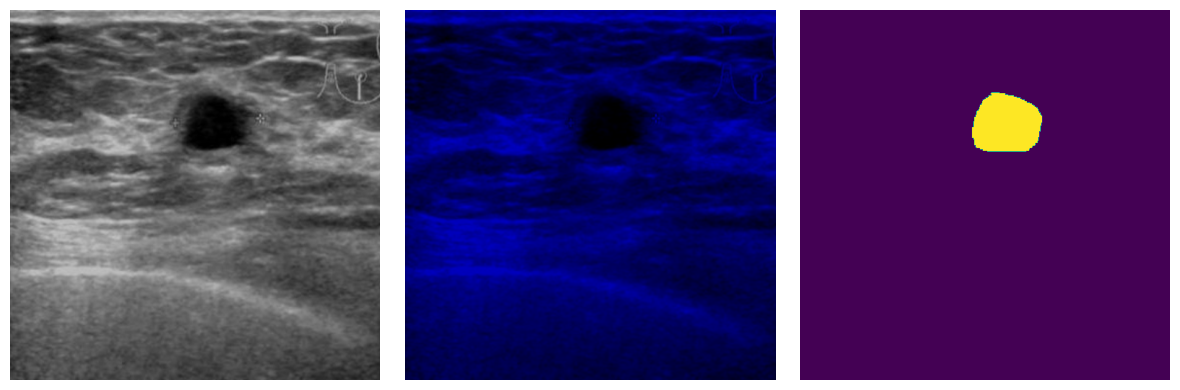

In [6]:
i = 10
display(ds_hf[i])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].imshow(ds_hf[i]["original_image"])
ax[0].set_axis_off()
ax[1].imshow(ds_hf[i]["pixel_values"])
ax[1].set_axis_off()
ax[2].imshow(ds_hf[i]["label"])
ax[2].set_axis_off()
fig.tight_layout()
plt.show()


# Augmentations and feature extraction

Load the transform functions used for image augmentation.

In [7]:
# the workhorse of feature extraction
# image transforms are built around it
builtins.feature_extractor = SegformerFeatureExtractor(
    do_normalize=True
).from_pretrained(builtins.model_name_full)

from train_val_transforms import train_transforms, val_transforms, val_transforms_check


Test the functions.

`train_transforms()` should generate a different output every time you run the next cell.

The other two transforms should stay the same.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


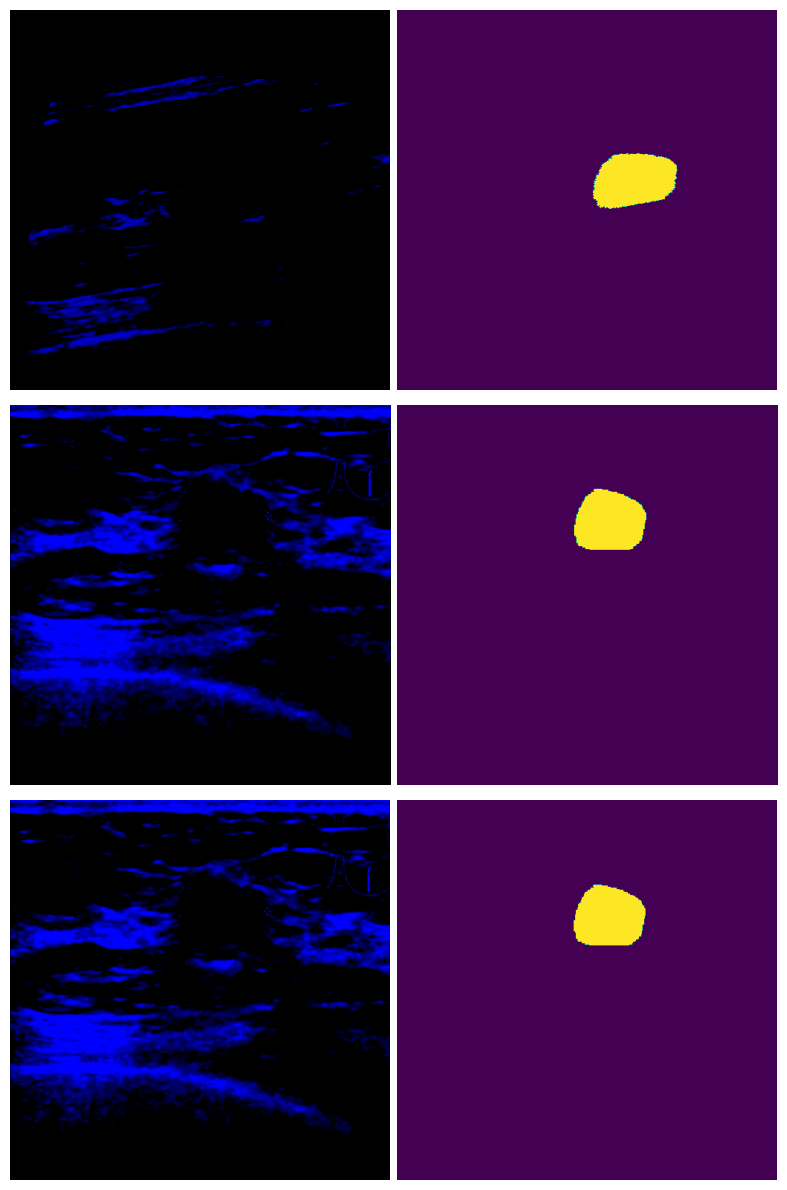

In [8]:
# passing control variables to transform functions
builtins.APPLY_CLICKS_TRAIN_DS = False
builtins.APPLY_CLICKS_TEST_DS = False

i = 10
tt_out = train_transforms(ds_hf[i : i + 1])
vt_out = val_transforms(ds_hf[i : i + 1])
vtc_out = val_transforms_check(ds_hf[i : i + 1])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
ax[0, 0].imshow(np.moveaxis(tt_out["pixel_values"][0], 0, -1))
ax[0, 0].set_axis_off()
ax[0, 1].imshow(tt_out["labels"][0])
ax[0, 1].set_axis_off()
ax[1, 0].imshow(np.moveaxis(vt_out["pixel_values"][0], 0, -1))
ax[1, 0].set_axis_off()
ax[1, 1].imshow(vt_out["labels"][0])
ax[1, 1].set_axis_off()
ax[2, 0].imshow(np.moveaxis(vtc_out["pixel_values"][0], 0, -1))
ax[2, 0].set_axis_off()
ax[2, 1].imshow(vtc_out["labels"][0])
ax[2, 1].set_axis_off()
fig.tight_layout()
plt.show()


# Load pretrained model, fine tune it on labeled datasets

Split the main dataset in 5 folds. Train 5 baseline models using the 5-fold split. Save each model.

Generate and save predictions for each baseline model. Collect performance metrics for each model.

This way, we can generate predictions for each image in the main dataset.

In [9]:
from model_functions import objective, generate_predictions


In [10]:
os.makedirs(model_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)
os.makedirs(folds_dir, exist_ok=True)

predictions_path = baseline_dir + "/predictions"

# baseline models do not use clicks for training
builtins.APPLY_CLICKS_TRAIN_DS = False
builtins.APPLY_CLICKS_TEST_DS = False

if os.path.exists(predictions_path):
    RUN_BASELINE_PREDICTIONS = False
else:
    RUN_BASELINE_PREDICTIONS = True

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
performance_metrics = {}
fold_metrics_training = {}
for train_index, test_index in skf.split(
    train_df.index.to_list(), train_df["dataset_tumor"]
):
    # shuffle the train order to mix all datasets together
    # test order doesn't matter
    rng = np.random.default_rng(seed=1)
    rng.shuffle(train_index)

    fold += 1
    print("\n###################################################")
    print(f"fold {fold}")
    train_ds = ds_hf.select(train_index)
    # the model only accepts certain columns in the test_ds while training
    # so we create two test_ds datasets
    # this is for the model training, only has image and label
    test_ds = ds_hf.select(test_index)
    # this is for generating predictions with a trained model, and has all image attributes
    test_ds_check = ds_hf.select(test_index)

    train_ds.set_transform(train_transforms)
    test_ds.set_transform(val_transforms)
    test_ds_check.set_transform(val_transforms_check)

    if not os.path.exists(model_dir + "/fold-" + str(fold).zfill(10)):
        print("model does not exist, train it")
        fold_metrics_training[fold] = objective(
            fold=fold,
            train_ds=train_ds,
            test_ds=test_ds,
            model_dir=model_dir,
            logging_dir=logging_dir,
            output_dir=output_dir,
            folds_dir=folds_dir,
            epochs=num_epochs,
        )
        print()
        print(
            "mean performance per fold, from total pixel counts across the entire fold, measured during training:"
        )
        print(pd.DataFrame(fold_metrics_training[fold], index=["values"]).T)
    else:
        print("model exists, do not train it")

    if RUN_BASELINE_PREDICTIONS:
        print("load trained model to evaluate performance")
        best_model_dir = model_dir + "/fold-" + str(fold).zfill(10)
        logging.set_verbosity(50)
        model = SegformerForSemanticSegmentation.from_pretrained(
            best_model_dir, id2label=id2label, label2id=label2id, num_labels=num_labels
        )
        model.to("cuda:0")
        logging.set_verbosity(40)

        performance_metrics_fold = generate_predictions(
            model=model, test_ds=test_ds_check, pr_path=predictions_path
        )
        for k, v in performance_metrics_fold.items():
            performance_metrics[k] = v

        del model
        torch.cuda.empty_cache()

if len(fold_metrics_training.keys()) == 5:
    with open(baseline_dir + "/fold_metrics_training.json", "w") as pfile:
        json.dump(fold_metrics_training, pfile, indent=2)

if RUN_BASELINE_PREDICTIONS:
    with open(predictions_path + ".json", "w") as pfile:
        json.dump(performance_metrics, pfile, indent=2)



###################################################
fold 1
model exists, do not train it

###################################################
fold 2
model exists, do not train it

###################################################
fold 3
model exists, do not train it

###################################################
fold 4
model exists, do not train it

###################################################
fold 5
model exists, do not train it


Dataframe with performance metrics of predictions for each image.

In [11]:
with open(predictions_path + ".json", "r") as pfile:
    performance_metrics = json.load(pfile)
    performance_metrics = {int(k): v for k, v in performance_metrics.items()}

image_perf_df = train_df[["dataset", "tumor", "dataset_tumor"]].copy()
image_perf_df["iou"] = [
    performance_metrics[x]["per_category_niou"][1]
    for x in range(len(performance_metrics.keys()))
]
image_perf_df["dice"] = [
    performance_metrics[x]["per_category_dice"][1]
    for x in range(len(performance_metrics.keys()))
]
image_perf_df["precision"] = [
    performance_metrics[x]["per_category_precision"][1]
    for x in range(len(performance_metrics.keys()))
]
image_perf_df["recall"] = [
    performance_metrics[x]["per_category_recall"][1]
    for x in range(len(performance_metrics.keys()))
]
image_perf_df["area_label"] = [
    performance_metrics[x]["total_area_label"][1]
    for x in range(len(performance_metrics.keys()))
]
image_perf_df["area_pred"] = [
    performance_metrics[x]["total_area_pred"][1]
    for x in range(len(performance_metrics.keys()))
]
image_perf_df.to_csv(baseline_dir + "/image_perf_df.csv")
image_perf_df


dataset      tumor    dataset_tumor       iou      dice  precision  \
0      BUSIS     benign     BUSIS_benign  0.906663  0.951047   0.910626   
1      BUSIS  malignant  BUSIS_malignant  0.885145  0.939074   0.896054   
2      BUSIS  malignant  BUSIS_malignant  0.766310  0.867696   0.804631   
3      BUSIS     benign     BUSIS_benign  0.847363  0.917376   0.985499   
4      BUSIS  malignant  BUSIS_malignant  0.908603  0.952113   0.937337   
...      ...        ...              ...       ...       ...        ...   
1789    Mayo     benign      Mayo_benign  0.808152  0.893898   0.878307   
1790    Mayo  malignant   Mayo_malignant  0.259972  0.412663   1.000000   
1791    Mayo     benign      Mayo_benign  0.799889  0.888820   0.864458   
1792    Mayo     benign      Mayo_benign  0.795242  0.885944   0.944564   
1793    Mayo     benign      Mayo_benign  0.669332  0.801916   0.946833   

        recall  area_label  area_pred  
0     0.995223     38310.0    41869.0  
1     0.986432     60954.0    67102.0  
2     0.941487     17791.0    20817.0  
3     0.858062     20988.0    18274.0  
4     0.967362     62780.0    64791.0  
...        ...         ...        ...  
1789  0.910052      9739.0    10091.0  
1790  0.259972      4262.0     1108.0  
1791  0.914595      1569.0     1660.0  
1792  0.834176      3166.0     2796.0  
1793  0.695472      2407.0     1768.0  

[1794 rows x 9 columns]

# Generate true positives, false positives, false negatives from predictions

For each image, use its mask prediction and extract TP, FP, FN areas. Split each area into contiguous segments. Save all segments as NumPy arrays.

If multiprocessing is used in the code, and then dataloaders are invoked later,

the dataloaders may break. The problem is either in PyTorch or in the Transformers library.

We've moved multiprocessing to separate scripts wherever it occurs.

In [12]:
! python3 ./make_segments.py {baseline_dir} {train_dataset_path} {predictions_path}


Segment files directory model_baseline_mit-b5/segment_files exists. Segment stats file model_baseline_mit-b5/segment_stats.csv exists. Exit.


Dataframe with attributes of TP, FP, FN segments

In [13]:
segment_stats = pd.read_csv(baseline_dir + "/segment_stats.csv", index_col=0)
segment_stats


image_index       iou  segment_index     segment_type  segment_size
0                0  0.906663              1  false_positives             9
1                0  0.906663              2  false_positives           190
2                0  0.906663              3  false_positives             1
3                0  0.906663              4  false_positives             4
4                0  0.906663              5  false_positives           131
...            ...       ...            ...              ...           ...
27837         1793  0.669332              4  false_positives             1
27838         1793  0.669332              1  false_negatives           726
27839         1793  0.669332              2  false_negatives             3
27840         1793  0.669332              3  false_negatives             4
27841         1793  0.669332              1   true_positives          1674

[27842 rows x 5 columns]

# Generate clicks from TP, FP, FN segments

Use Voronoi tiling, via simulated annealing, to generate positive and negative clicks filling some of the TP, FP, FN segments.

Only big-enough segments generate clicks.

Only images with IoU below some threshold will have clicks.

There is a maximum budget of clicks per image, to prevent click spam.

Save click coordinates.

Also save the output ("energy") from simulated annealing, for troubleshooting.

In [14]:
! python3 ./uniform_clicks.py {baseline_dir}


Segment energy maps directory model_baseline_mit-b5/energy exists. Guide clicks file model_baseline_mit-b5/guide_clicks.json exists. Exit.


Click coordinates generated from segments

True positives are counted separately - positive clicks are generated separately for true and for false positives.

In [15]:
with open(baseline_dir + "/guide_clicks.json", "r") as gcfile:
    guide_clicks = json.load(gcfile)
    guide_clicks = {int(k): v for k, v in guide_clicks.items()}

i = 0
for k, v in guide_clicks.items():
    i += 1
    print(k, v)
    if i > 5:
        break


0 {'clicks_positive_tp': [[240, 210], [153, 266], [213, 390], [227, 295]], 'clicks_negative': [[285, 268], [192, 178]], 'clicks_positive': []}
1 {'clicks_positive_tp': [[227, 419], [114, 328], [190, 261], [277, 339]], 'clicks_negative': [[243, 501], [289, 488], [243, 200]], 'clicks_positive': []}
2 {'clicks_positive_tp': [[222, 288], [286, 262], [348, 274]], 'clicks_negative': [[383, 248], [214, 240]], 'clicks_positive': []}
3 {'clicks_positive_tp': [[100, 204], [121, 261], [110, 311]], 'clicks_negative': [], 'clicks_positive': [[172, 337]]}
4 {'clicks_positive_tp': [[189, 433], [168, 201], [218, 279], [244, 380]], 'clicks_negative': [[316, 262]], 'clicks_positive': []}
5 {'clicks_positive_tp': [[227, 349], [143, 287], [240, 280]], 'clicks_negative': [[137, 226]], 'clicks_positive': []}


# Sample a few images, segments, and clicks

## Segment colors

white = TP

green = FP

red = FN

yellow = original mask (label)

## Click colors

green = activating clicks

red = inhibitory clicks

  0%|          | 0/6 [00:00<?, ?it/s]

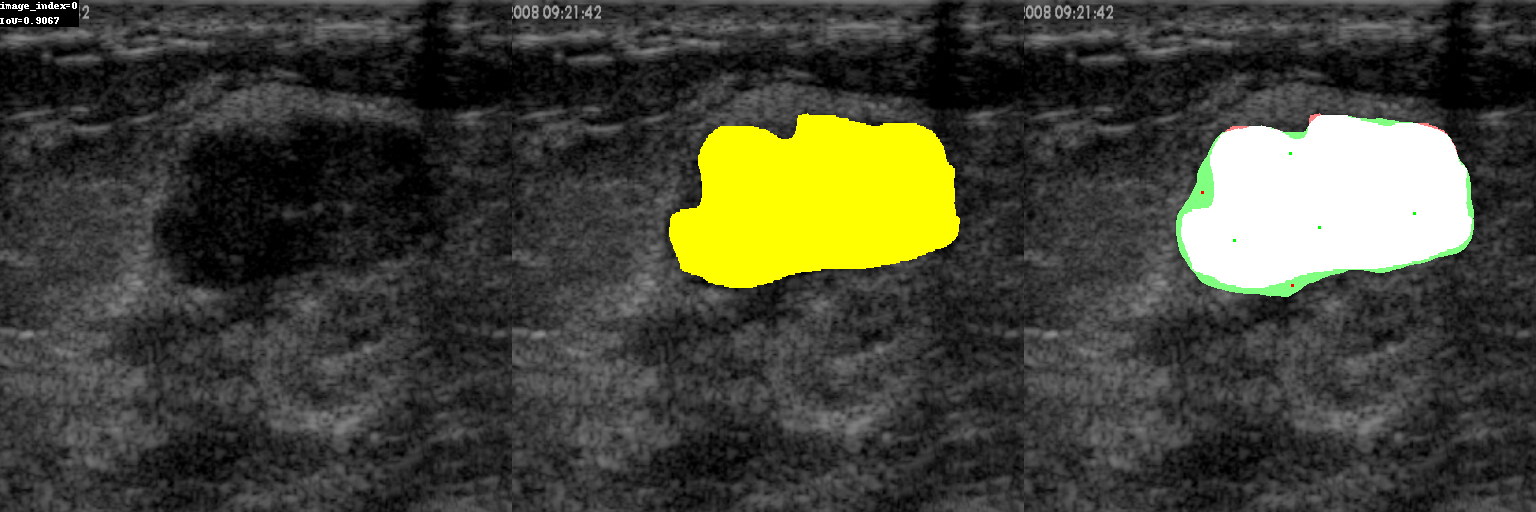

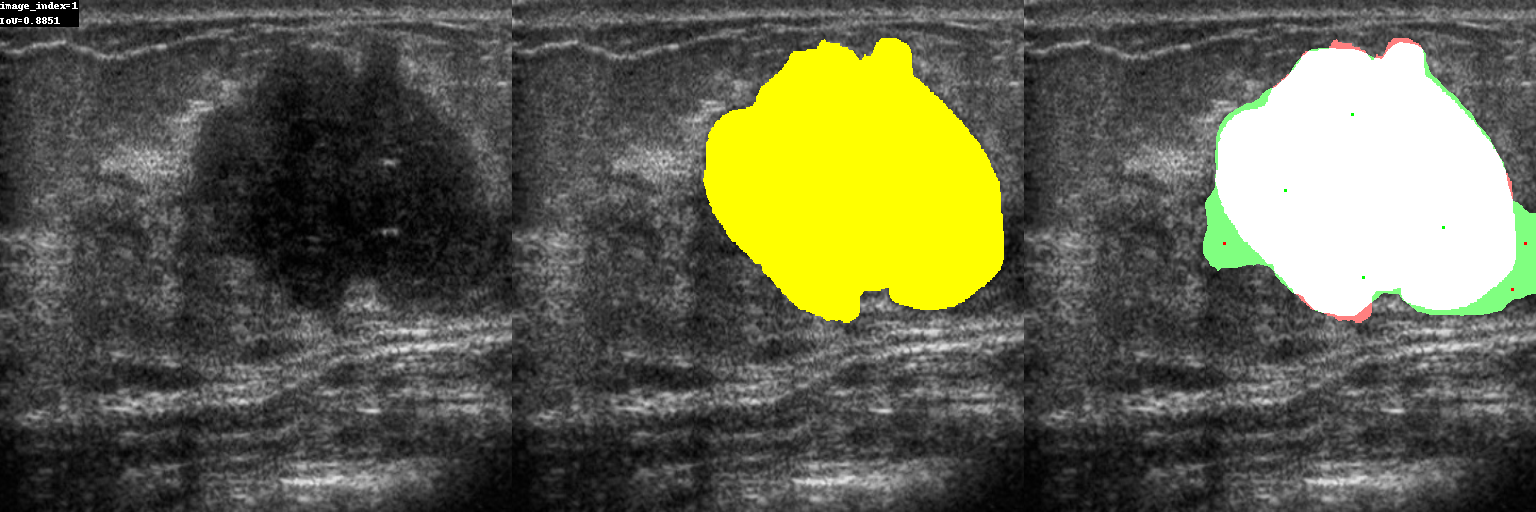

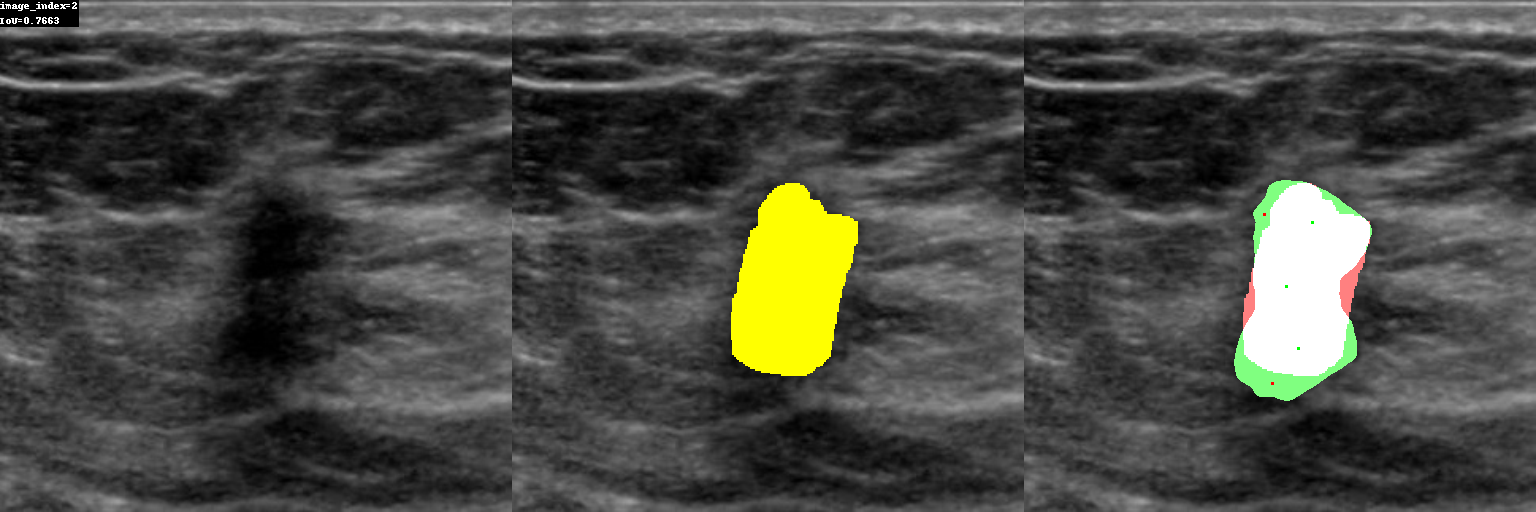

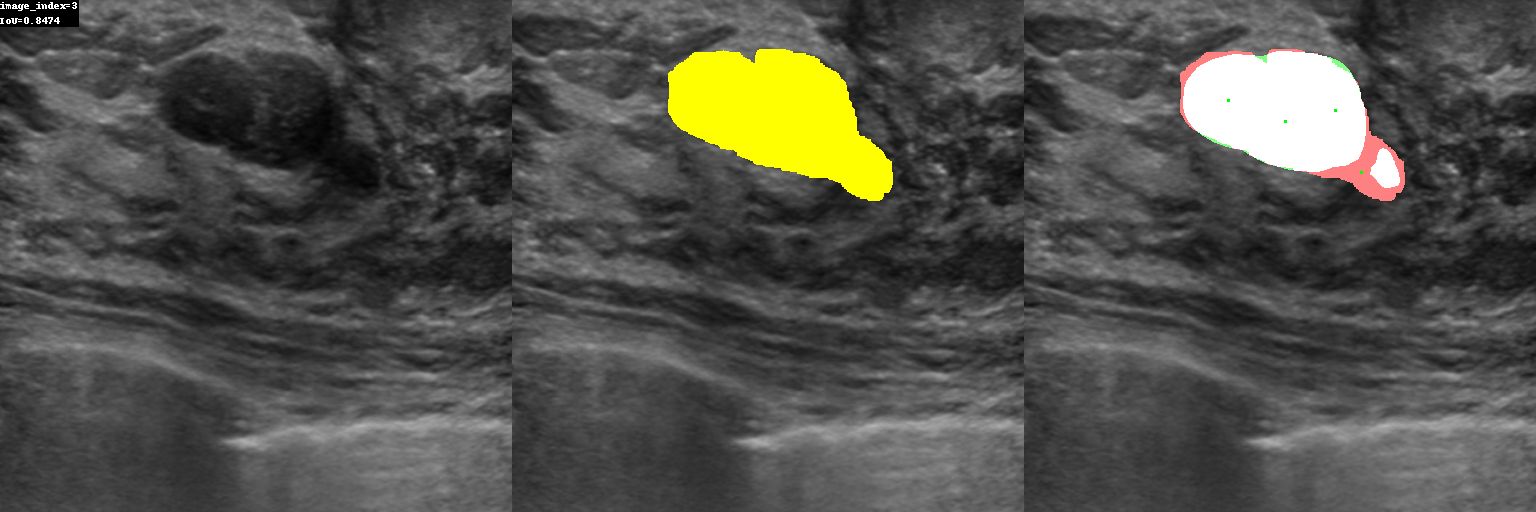

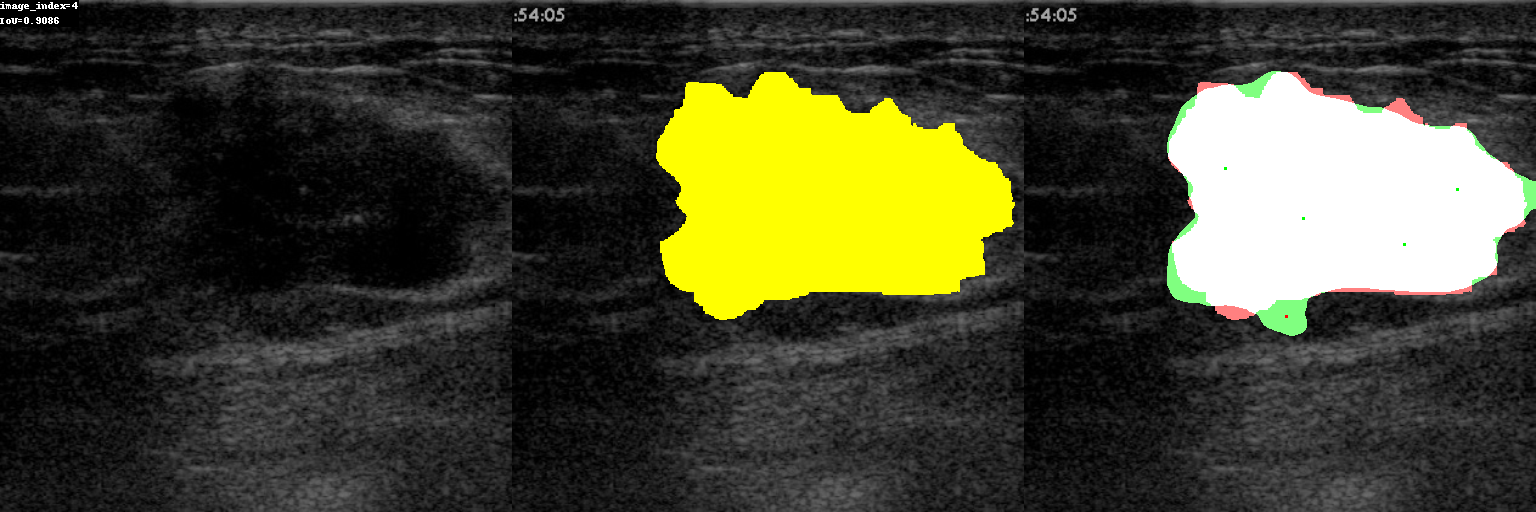

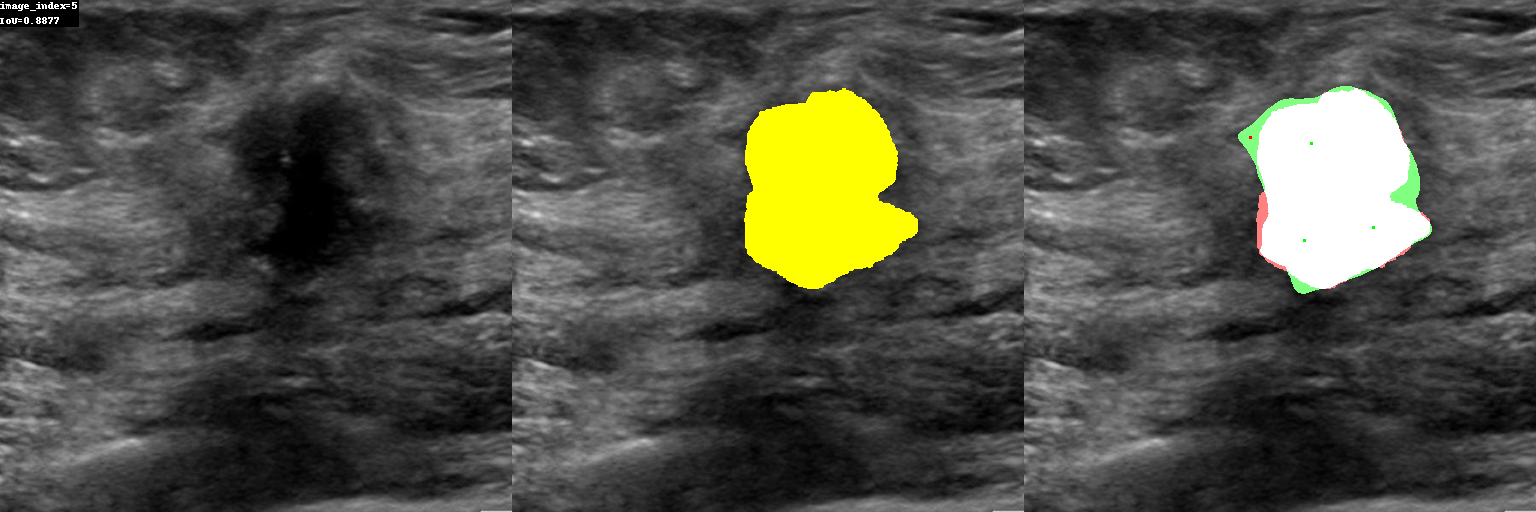

In [16]:
s_color = {
    "true_positives": [255, 255, 255],
    "false_positives": [128, 255, 128],
    "false_negatives": [255, 128, 128],
}

segment_files = baseline_dir + "/segment_files"

for i in tqdm(range(0, 6)):
    original_image = ds_hf[i]["original_image"]

    image_stats = segment_stats[segment_stats["image_index"] == i]
    clicks = guide_clicks[i]

    label_arr = np.array(ds_hf[i]["label"], dtype=np.uint8) * 255
    label_img = ImageOps.colorize(
        Image.fromarray(label_arr, mode="L"),
        black=[0, 0, 0],
        white=[255, 255, 0],
        blackpoint=0,
        whitepoint=255,
    )
    img_label_merged = Image.composite(
        label_img, original_image, Image.fromarray(label_arr, mode="L")
    )

    s_merged = original_image
    for st in s_color.keys():
        st_stats = image_stats[image_stats["segment_type"] == st]
        for s in st_stats.iterrows():
            with open(
                segment_files
                + "/"
                + str(i)
                + "/"
                + st
                + "/"
                + str(s[1]["segment_index"])
                + ".pkl",
                "rb",
            ) as s_file:
                s_arr = pickle.load(s_file)
                s_arr = s_arr * 255
                s_img = ImageOps.colorize(
                    Image.fromarray(s_arr, mode="L"),
                    black=[0, 0, 0],
                    white=s_color[st],
                    blackpoint=0,
                    whitepoint=255,
                )
                s_merged = Image.composite(
                    s_img, s_merged, Image.fromarray(s_arr, mode="L")
                )

    for c in clicks["clicks_positive_tp"]:
        # Pillow and Numpy disagree on the meaning of X and Y
        # we use the Numpy convention
        # so for Pillow we swap X and Y
        ImageDraw.Draw(s_merged).rectangle(
            xy=[(c[1] - 1, c[0] - 1), (c[1] + 1, c[0] + 1)],
            outline=(0, 255, 0),
            fill=(0, 255, 0),
            width=1,
        )

    for c in clicks["clicks_positive"]:
        # Pillow and Numpy disagree on the meaning of X and Y
        # we use the Numpy convention
        # so for Pillow we swap X and Y
        ImageDraw.Draw(s_merged).rectangle(
            xy=[(c[1] - 1, c[0] - 1), (c[1] + 1, c[0] + 1)],
            outline=(0, 255, 0),
            fill=(0, 255, 0),
            width=1,
        )

    for c in clicks["clicks_negative"]:
        # Pillow and Numpy disagree on the meaning of X and Y
        # we use the Numpy convention
        # so for Pillow we swap X and Y
        ImageDraw.Draw(s_merged).rectangle(
            xy=[(c[1] - 1, c[0] - 1), (c[1] + 1, c[0] + 1)],
            outline=(255, 0, 0),
            fill=(255, 0, 0),
            width=1,
        )

    oi_text = "image_index=" + str(i)
    oi_text += "\n" + "IoU=" + str(round(image_perf_df.loc[i, "iou"], ndigits=4))
    draw = ImageDraw.Draw(original_image)
    bbox = draw.multiline_textbbox((0, 0), oi_text)
    draw.rectangle(bbox, fill="black")
    draw.text((0, 0), oi_text)

    big_frame = Image.new(
        mode="RGB",
        size=(builtins.image_size[0] * 3, builtins.image_size[0]),
        color=(0, 0, 0),
    )
    big_frame.paste(original_image, box=(0, 0))
    big_frame.paste(img_label_merged, box=(builtins.image_size[0], 0))
    big_frame.paste(s_merged, box=(builtins.image_size[0] * 2, 0))
    display(big_frame)


# Check the energy maps for a few segments

The outputs from simulated annealing for each segment that has generated clicks. The outputs are heat maps showing the "energy" optimized by simulated annealing.

This is to make sure the click generator works properly.

If no clicks were generated for a type of segments, the energy map is empty.

image index: 0


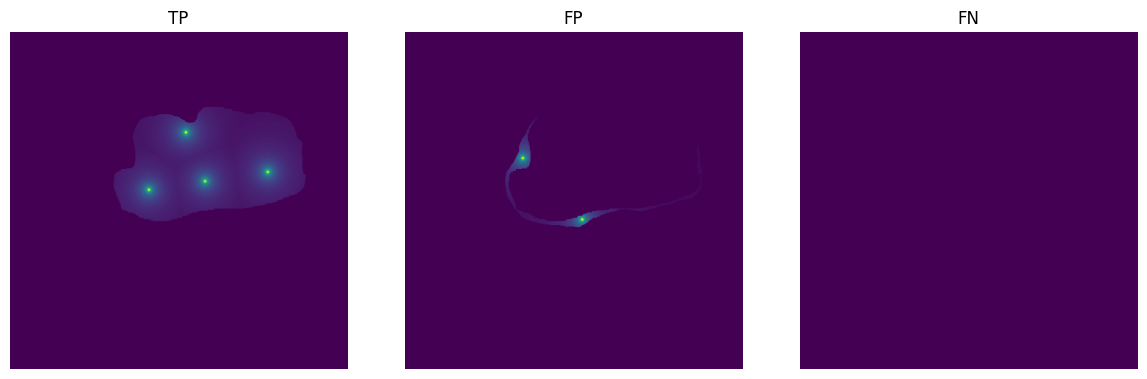

image index: 1


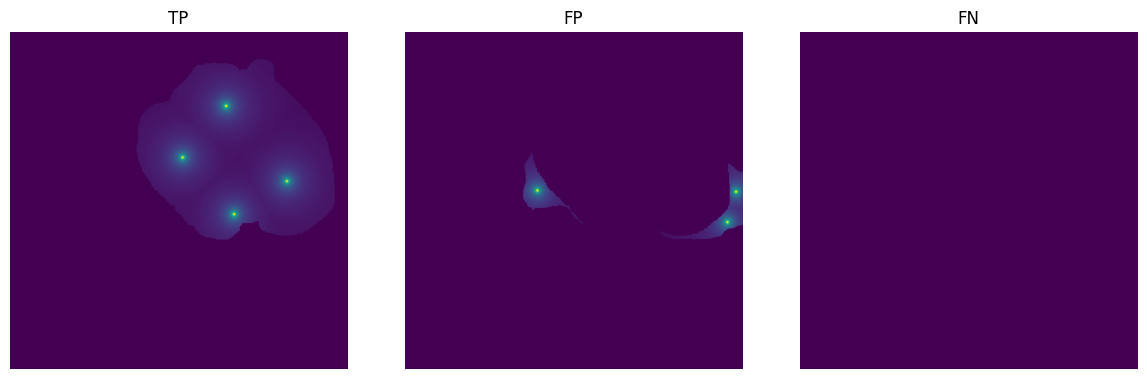

image index: 2


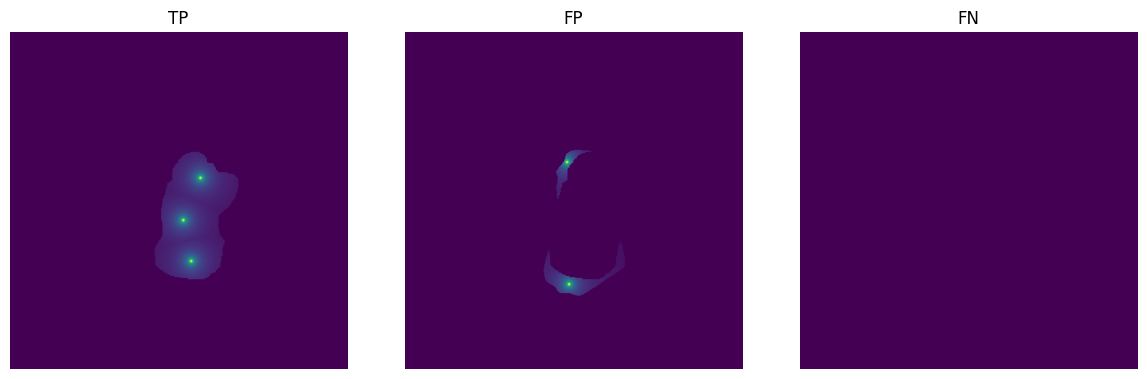

image index: 3


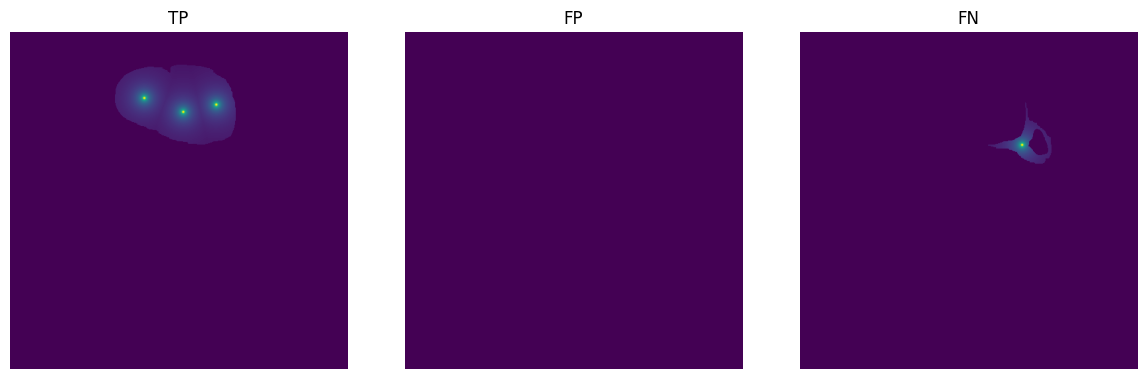

image index: 4


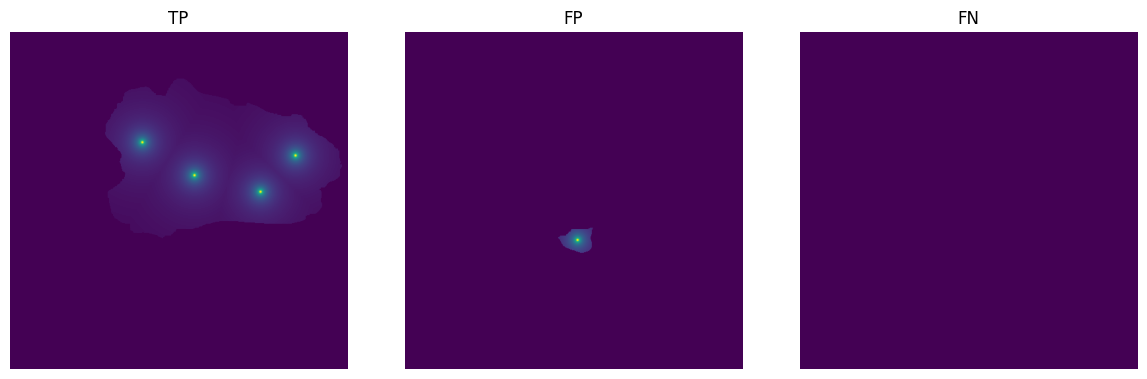

image index: 5


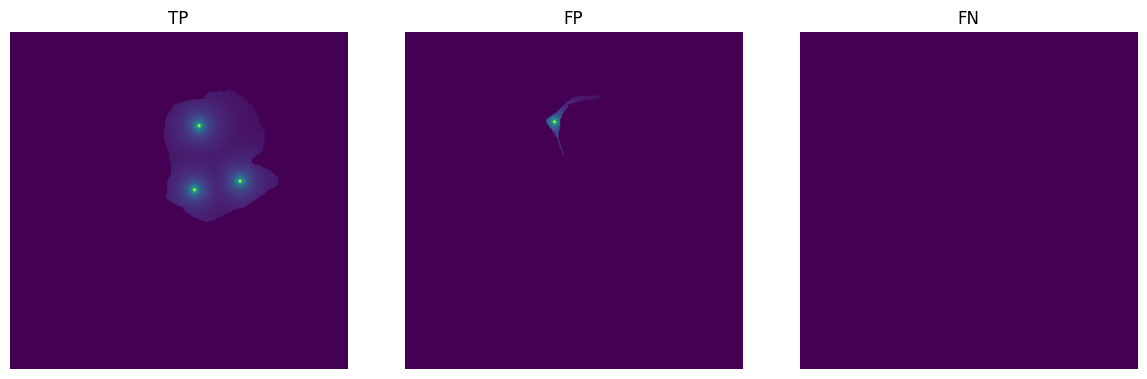

In [17]:
for i in range(0, 6):
    print("image index:", i)
    seg_dir = baseline_dir + "/energy/" + str(i) + "/true_positives"
    tp_arr = np.zeros(builtins.image_size, dtype=np.float64)
    if os.path.exists(seg_dir):
        for f in os.listdir(seg_dir):
            with open(seg_dir + "/" + f, "rb") as arr_file:
                tp_arr += pickle.load(arr_file)
    seg_dir = baseline_dir + "/energy/" + str(i) + "/false_positives"
    fp_arr = np.zeros(builtins.image_size, dtype=np.float64)
    if os.path.exists(seg_dir):
        for f in os.listdir(seg_dir):
            with open(seg_dir + "/" + f, "rb") as arr_file:
                fp_arr += pickle.load(arr_file)
    seg_dir = baseline_dir + "/energy/" + str(i) + "/false_negatives"
    fn_arr = np.zeros(builtins.image_size, dtype=np.float64)
    if os.path.exists(seg_dir):
        for f in os.listdir(seg_dir):
            with open(seg_dir + "/" + f, "rb") as arr_file:
                fn_arr += pickle.load(arr_file)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.8))
    ax[0].set_title("TP")
    ax[1].set_title("FP")
    ax[2].set_title("FN")
    ax[0].imshow(np.log10(tp_arr + 0.1))
    ax[0].set_axis_off()
    ax[1].imshow(np.log10(fp_arr + 0.1))
    ax[1].set_axis_off()
    ax[2].imshow(np.log10(fn_arr + 0.1))
    ax[2].set_axis_off()
    fig.tight_layout()
    plt.show()


# Segment stats

Stats for the TP, FP, FN segments.

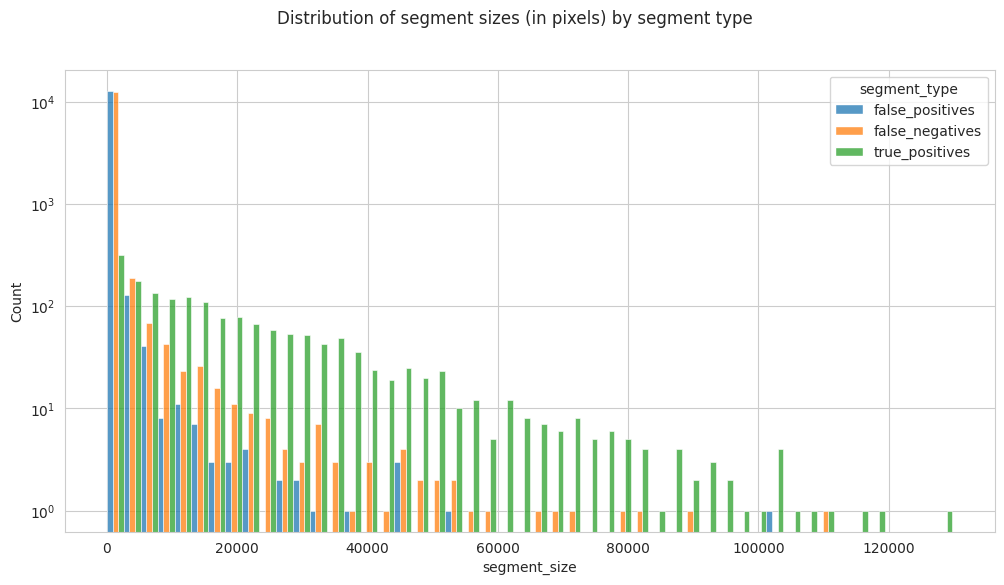

In [18]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    bins=50,
    multiple="dodge",
    data=segment_stats,
    x="segment_size",
    hue="segment_type",
    ax=ax,
)
fig.suptitle("Distribution of segment sizes (in pixels) by segment type")
plt.yscale("log")
matplotlib.rc_file_defaults()


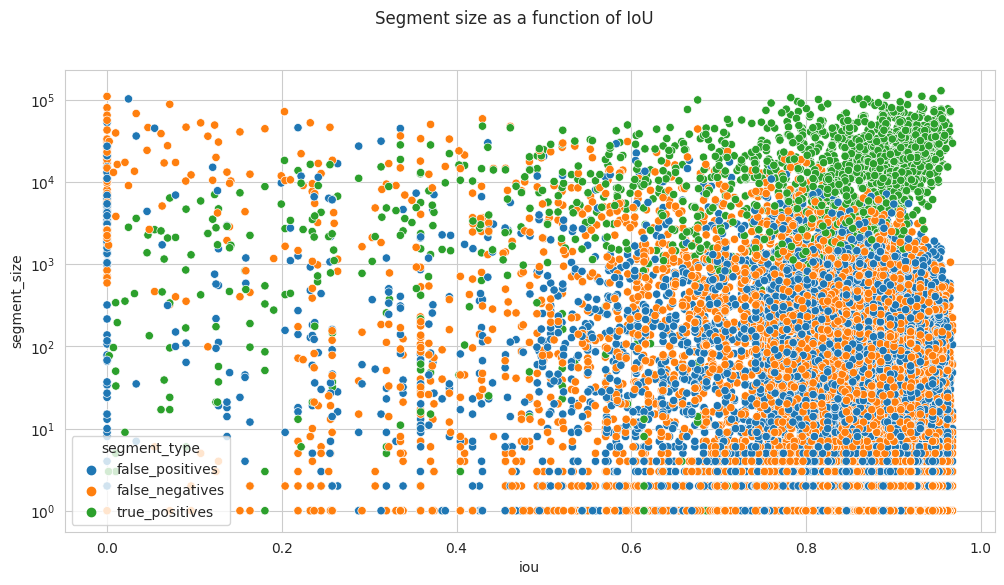

In [19]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(
    data=segment_stats, x="iou", y="segment_size", hue="segment_type", ax=ax
)
fig.suptitle("Segment size as a function of IoU")
plt.yscale("log")
matplotlib.rc_file_defaults()


# For each image, merge all positive clicks together

Positive clicks for TP were generated separately from positive clicks for FN (different criteria).

Now we will use the clicks to train models, and the distinction is not necessary anymore: all positive clicks can be stored together.

In [20]:
builtins.guide_clicks = {}
with open(baseline_dir + "/guide_clicks.json", "r") as gcfile:
    guide_clicks_split = json.load(gcfile)
    for k, v in guide_clicks_split.items():
        v["clicks_positive"] += v["clicks_positive_tp"]
        _ = v.pop("clicks_positive_tp", None)
        builtins.guide_clicks[int(k)] = v

i = 0
for k, v in builtins.guide_clicks.items():
    i += 1
    print(k, v)
    if i > 5:
        break


0 {'clicks_negative': [[285, 268], [192, 178]], 'clicks_positive': [[240, 210], [153, 266], [213, 390], [227, 295]]}
1 {'clicks_negative': [[243, 501], [289, 488], [243, 200]], 'clicks_positive': [[227, 419], [114, 328], [190, 261], [277, 339]]}
2 {'clicks_negative': [[383, 248], [214, 240]], 'clicks_positive': [[222, 288], [286, 262], [348, 274]]}
3 {'clicks_negative': [], 'clicks_positive': [[172, 337], [100, 204], [121, 261], [110, 311]]}
4 {'clicks_negative': [[316, 262]], 'clicks_positive': [[189, 433], [168, 201], [218, 279], [244, 380]]}
5 {'clicks_negative': [[137, 226]], 'clicks_positive': [[227, 349], [143, 287], [240, 280]]}


# Check image transform functions (augmentations) with clicks applied

Generate a few toy datasets, display them, delete them after that.

Train images and labels have geometric transforms applied.

Test images and labels do not have geometric transforms applied.

Clicks should be visible, where any were generated.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


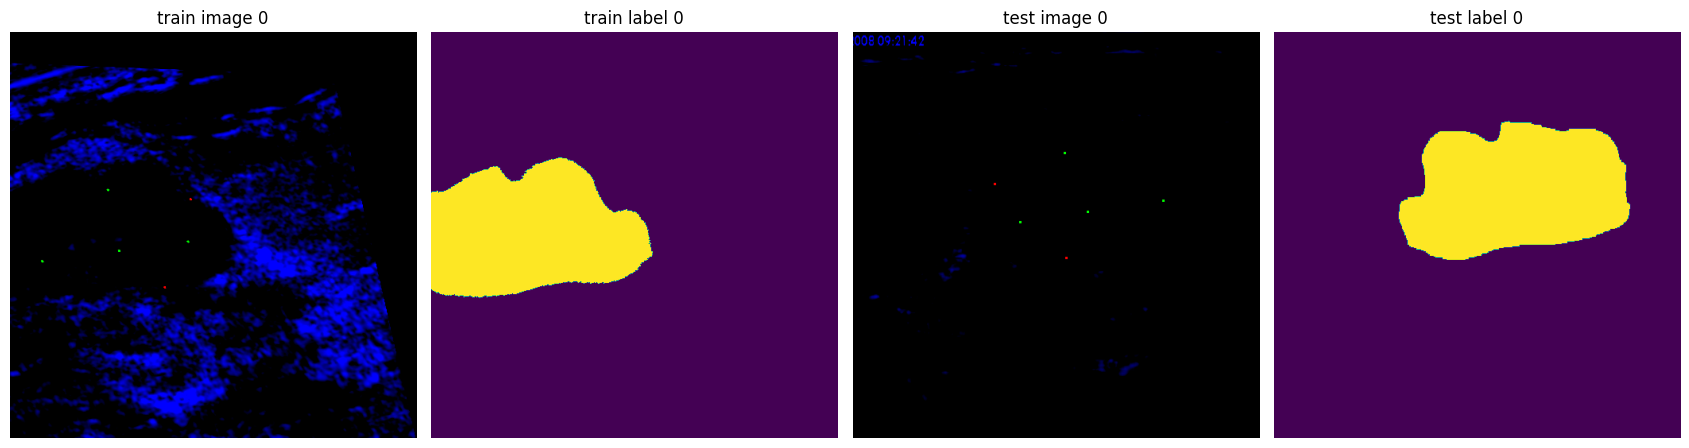

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


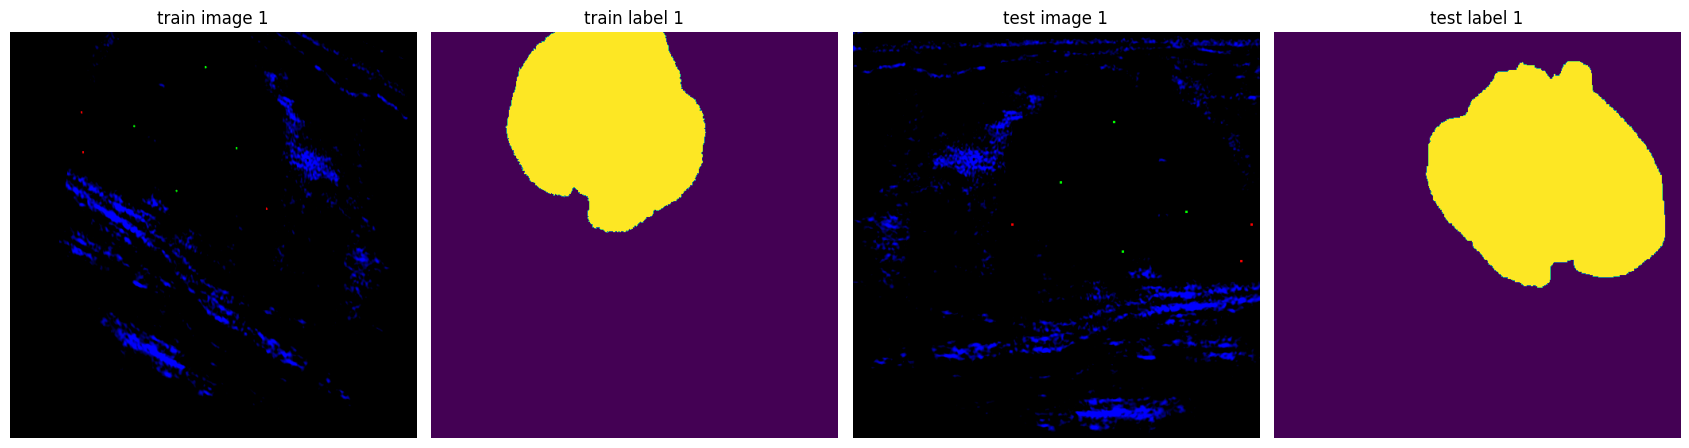

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


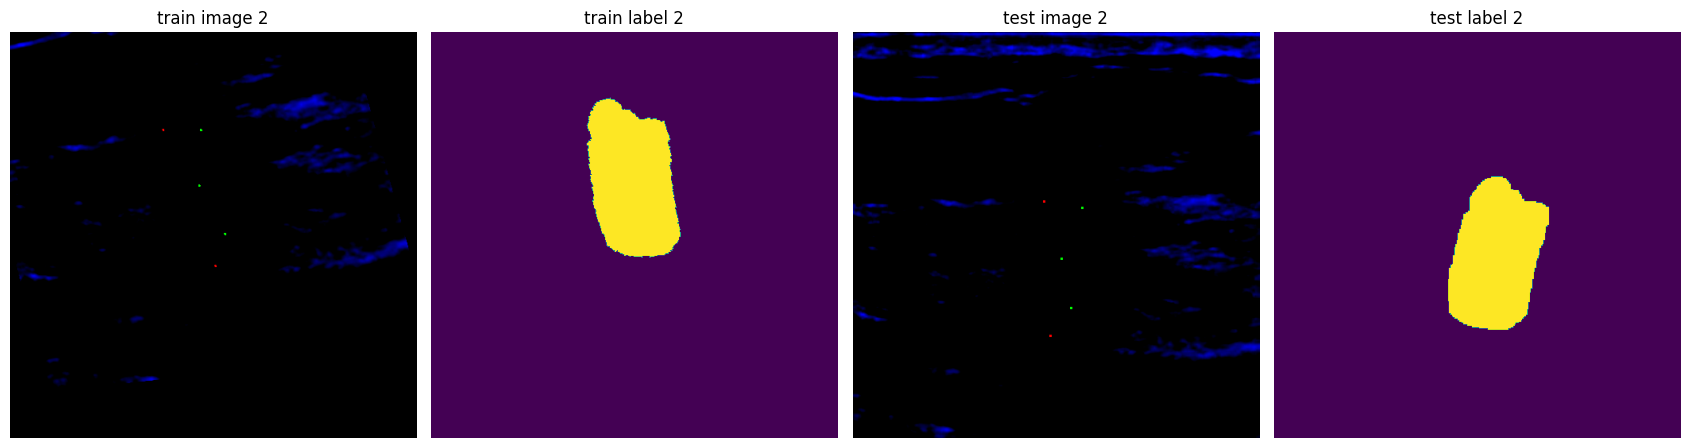

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


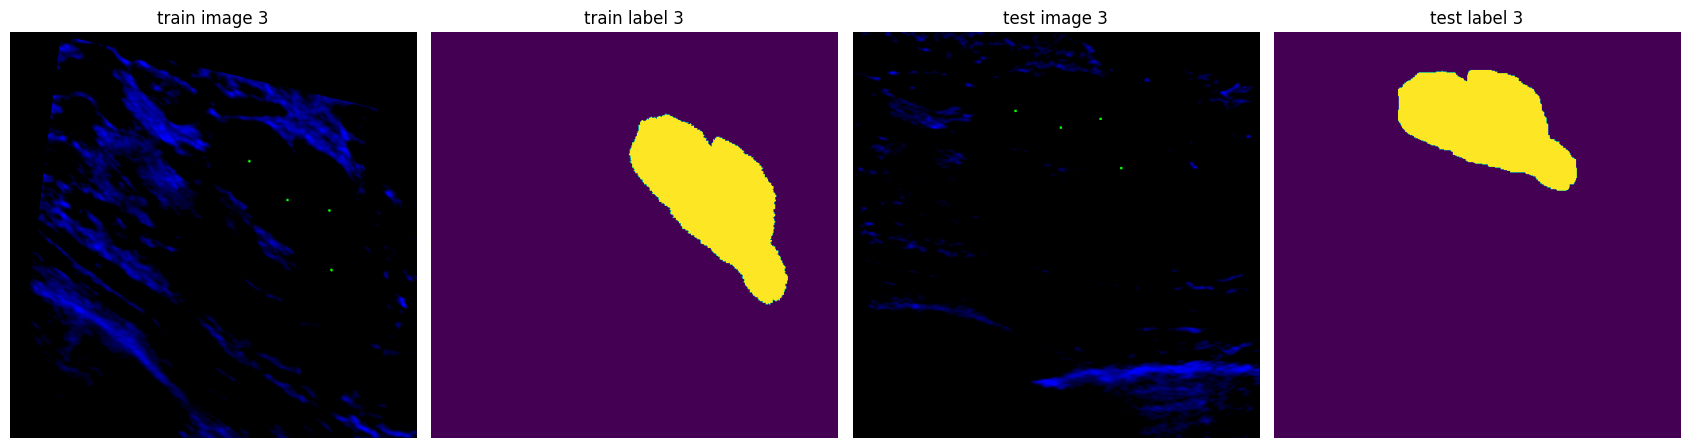

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


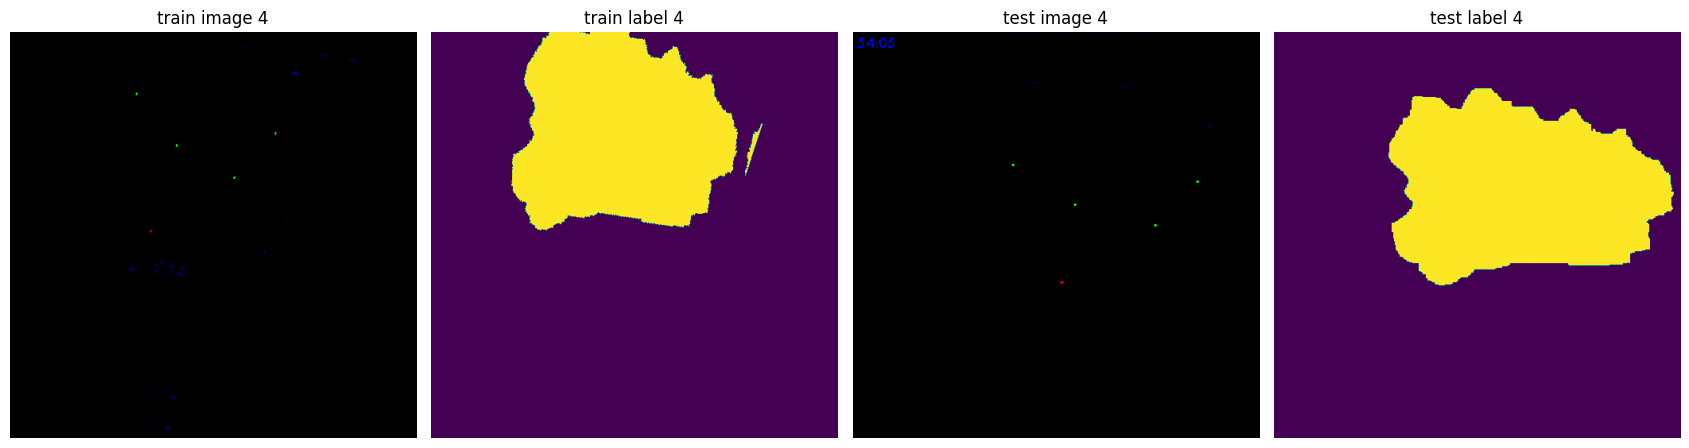

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


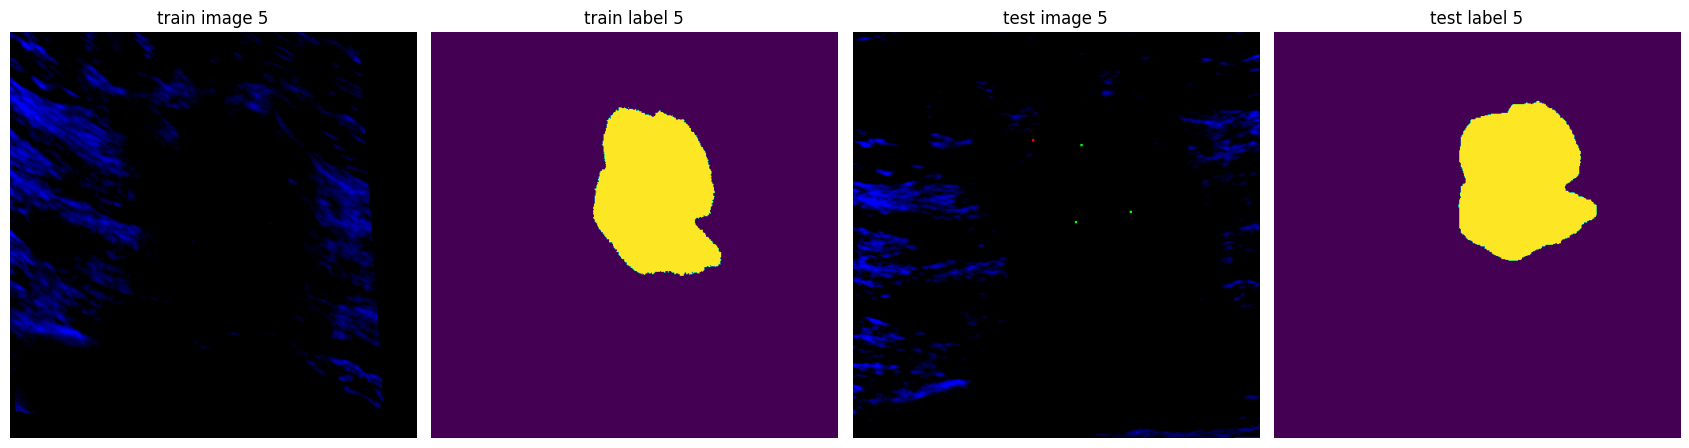

In [21]:
train_index = list(range(6))
test_index = train_index

builtins.APPLY_CLICKS_TRAIN_DS = True
train_ds = ds_hf.select(train_index)
train_ds.set_transform(train_transforms)

# the model only accepts certain columns in the test_ds while training
# so we create two test_ds datasets
# this is for the model training, only has image and label
test_ds = ds_hf.select(test_index)
# this is for generating predictions with a trained model, and has all image attributes
test_ds_check = ds_hf.select(test_index)

builtins.APPLY_CLICKS_TEST_DS = True
test_ds.set_transform(val_transforms)
test_ds_check.set_transform(val_transforms_check)

for i in train_index:
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17, 8))
    train_item = train_ds[i]
    test_item = test_ds[i]
    ax[0].imshow(np.moveaxis(train_item["pixel_values"], 0, -1))
    ax[0].set_title("train image " + str(i))
    ax[0].set_axis_off()
    ax[1].imshow(train_item["labels"])
    ax[1].set_title("train label " + str(i))
    ax[1].set_axis_off()
    ax[2].imshow(np.moveaxis(test_item["pixel_values"], 0, -1))
    ax[2].set_title("test image " + str(i))
    ax[2].set_axis_off()
    ax[3].imshow(test_item["labels"])
    ax[3].set_title("test label " + str(i))
    ax[3].set_axis_off()
    fig.tight_layout()
    plt.show()

del train_ds
del test_ds
del test_ds_check


# Train models with clicks

Using clicks inferred from the baseline model predictions, train new models to respond to clicks.

Same as the baseline models: 5-fold split, generate 5 separate models, save predictions and performance metrics.

Predictions will be generated with clicks, and without clicks. Prediction without clicks should be similar to the baseline models.

In [22]:
clicktrained_dir = "model_clicktrained_" + model_name

model_dir_clicks = clicktrained_dir + "/models"
output_dir_clicks = clicktrained_dir + "/outputs"
logging_dir_clicks = clicktrained_dir + "/logs"
folds_dir_clicks = clicktrained_dir + "/folds"

os.makedirs(model_dir_clicks, exist_ok=True)
os.makedirs(logging_dir_clicks, exist_ok=True)
os.makedirs(folds_dir_clicks, exist_ok=True)

predictions_path = clicktrained_dir + "/predictions"

test_cases = {
    "train clicks only": {
        "path_suffix": "_clicks_train",
        "apply_clicks_test_ds": False,
        "performance_metrics": {},
        "run_test_case": False,
    },
    "train and test clicks": {
        "path_suffix": "_clicks_train_test",
        "apply_clicks_test_ds": True,
        "performance_metrics": {},
        "run_test_case": False,
    },
}
for tc_name in test_cases.keys():
    if not os.path.exists(
        predictions_path
        + test_cases[tc_name]["path_suffix"]
        + "/performance_metrics.json"
    ):
        # if this specific performance_metrics.json does not exist, run this test case
        test_cases[tc_name]["run_test_case"] = True

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
fold = 0
performance_metrics_clicks = {}
fold_metrics_training_clicks = {}

for train_index, test_index in skf.split(
    train_df.index.to_list(), train_df["dataset_tumor"]
):
    # shuffle the train order to mix all datasets together
    # test order doesn't matter
    rng = np.random.default_rng(seed=1)
    rng.shuffle(train_index)

    fold += 1
    print("\n###################################################")
    print(f"fold {fold}")

    if not os.path.exists(model_dir_clicks + "/fold-" + str(fold).zfill(10)):
        print("model does not exist, train it")

        builtins.APPLY_CLICKS_TRAIN_DS = True
        train_ds = ds_hf.select(train_index)
        train_ds.set_transform(train_transforms)

        # the model only accepts certain columns in the test_ds while training
        # so we create two test_ds datasets
        # this is for training, only has image and label
        test_ds = ds_hf.select(test_index)
        # this is for testing, and has all image attributes
        test_ds_check = ds_hf.select(test_index)

        builtins.APPLY_CLICKS_TEST_DS = True
        test_ds.set_transform(val_transforms)
        test_ds_check.set_transform(val_transforms_check)

        fold_metrics_training_clicks[fold] = objective(
            fold=fold,
            train_ds=train_ds,
            test_ds=test_ds,
            model_dir=model_dir_clicks,
            logging_dir=logging_dir_clicks,
            output_dir=output_dir_clicks,
            folds_dir=folds_dir_clicks,
            epochs=num_epochs,
        )
        print()
        print(
            "mean performance per fold, from total pixel counts across the entire fold, measured during training:"
        )
        print(pd.DataFrame(fold_metrics_training_clicks[fold], index=["values"]).T)
    else:
        print("model exists, do not train it")

    for test_case_name in test_cases.keys():
        print()
        print(f"test case: {test_case_name}")
        if test_cases[tc_name]["run_test_case"]:
            pr_path = predictions_path + test_cases[test_case_name]["path_suffix"]
            print(f"load trained model to evaluate performance")
            best_model_dir_clicks = model_dir_clicks + "/fold-" + str(fold).zfill(10)
            logging.set_verbosity(50)
            model = SegformerForSemanticSegmentation.from_pretrained(
                best_model_dir_clicks,
                id2label=id2label,
                label2id=label2id,
                num_labels=num_labels,
            )
            model.to("cuda:0")
            logging.set_verbosity(40)

            test_ds_check = ds_hf.select(test_index)
            builtins.APPLY_CLICKS_TEST_DS = test_cases[test_case_name][
                "apply_clicks_test_ds"
            ]
            test_ds_check.set_transform(val_transforms_check)

            performance_metrics_fold = generate_predictions(
                model=model, test_ds=test_ds_check, pr_path=pr_path
            )
            for k, v in performance_metrics_fold.items():
                test_cases[test_case_name]["performance_metrics"][k] = v

            del model
            torch.cuda.empty_cache()
        else:
            print("test case has been measured already, skip it")

for test_case_name in test_cases.keys():
    if test_cases[tc_name]["run_test_case"]:
        with open(
            predictions_path
            + test_cases[test_case_name]["path_suffix"]
            + "/performance_metrics.json",
            "w",
        ) as pfile:
            json.dump(
                test_cases[test_case_name]["performance_metrics"], pfile, indent=2
            )

if len(fold_metrics_training_clicks.keys()) == 5:
    with open(clicktrained_dir + "/fold_metrics_training_clicks.json", "w") as pfile:
        json.dump(fold_metrics_training_clicks, pfile, indent=2)



###################################################
fold 1
model exists, do not train it

test case: train clicks only
test case has been measured already, skip it

test case: train and test clicks
test case has been measured already, skip it

###################################################
fold 2
model exists, do not train it

test case: train clicks only
test case has been measured already, skip it

test case: train and test clicks
test case has been measured already, skip it

###################################################
fold 3
model exists, do not train it

test case: train clicks only
test case has been measured already, skip it

test case: train and test clicks
test case has been measured already, skip it

###################################################
fold 4
model exists, do not train it

test case: train clicks only
test case has been measured already, skip it

test case: train and test clicks
test case has been measured already, skip it

#######################

# Extract all performance metrics for each image, for each model

For the click-trained models, get performance metrics when testing with and without clicks.

In [23]:
test_cases["baseline model"] = {}

for test_case_name in test_cases.keys():
    if test_case_name != "baseline model":
        with open(
            predictions_path
            + test_cases[test_case_name]["path_suffix"]
            + "/performance_metrics.json",
            "r",
        ) as pfile:
            pm_temp = json.load(pfile)
            test_cases[test_case_name]["performance_metrics"] = {
                int(k): v for k, v in pm_temp.items()
            }
    else:
        with open(
            baseline_dir + "/predictions.json",
            "r",
        ) as pfile:
            pm_temp = json.load(pfile)
            test_cases[test_case_name]["performance_metrics"] = {
                int(k): v for k, v in pm_temp.items()
            }

    test_cases[test_case_name]["image_perf_df"] = train_df[
        ["dataset", "tumor", "dataset_tumor"]
    ].copy()
    test_cases[test_case_name]["image_perf_df"]["iou"] = [
        test_cases[test_case_name]["performance_metrics"][x]["per_category_niou"][1]
        for x in range(len(test_cases[test_case_name]["performance_metrics"].keys()))
    ]
    test_cases[test_case_name]["image_perf_df"]["dice"] = [
        test_cases[test_case_name]["performance_metrics"][x]["per_category_dice"][1]
        for x in range(len(test_cases[test_case_name]["performance_metrics"].keys()))
    ]
    test_cases[test_case_name]["image_perf_df"]["precision"] = [
        test_cases[test_case_name]["performance_metrics"][x]["per_category_precision"][
            1
        ]
        for x in range(len(test_cases[test_case_name]["performance_metrics"].keys()))
    ]
    test_cases[test_case_name]["image_perf_df"]["recall"] = [
        test_cases[test_case_name]["performance_metrics"][x]["per_category_recall"][1]
        for x in range(len(test_cases[test_case_name]["performance_metrics"].keys()))
    ]
    test_cases[test_case_name]["image_perf_df"]["area_label"] = [
        test_cases[test_case_name]["performance_metrics"][x]["total_area_label"][1]
        for x in range(len(test_cases[test_case_name]["performance_metrics"].keys()))
    ]
    test_cases[test_case_name]["image_perf_df"]["area_pred"] = [
        test_cases[test_case_name]["performance_metrics"][x]["total_area_pred"][1]
        for x in range(len(test_cases[test_case_name]["performance_metrics"].keys()))
    ]
    print(test_case_name)
    display(test_cases[test_case_name]["image_perf_df"].head(5))


train clicks only


dataset      tumor    dataset_tumor       iou      dice  precision  \
0   BUSIS     benign     BUSIS_benign  0.922189  0.959519   0.930627   
1   BUSIS  malignant  BUSIS_malignant  0.876580  0.934231   0.886403   
2   BUSIS  malignant  BUSIS_malignant  0.832555  0.908627   0.961066   
3   BUSIS     benign     BUSIS_benign  0.932276  0.964951   0.955441   
4   BUSIS  malignant  BUSIS_malignant  0.914868  0.955542   0.980620   

     recall  area_label  area_pred  
0  0.990264     38310.0    40765.0  
1  0.987515     60954.0    67907.0  
2  0.861615     17791.0    15950.0  
3  0.974652     20988.0    21410.0  
4  0.931714     62780.0    59649.0

train and test clicks


dataset      tumor    dataset_tumor       iou      dice  precision  \
0   BUSIS     benign     BUSIS_benign  0.943831  0.971104   0.961233   
1   BUSIS  malignant  BUSIS_malignant  0.938607  0.968331   0.956030   
2   BUSIS  malignant  BUSIS_malignant  0.847446  0.917425   0.973566   
3   BUSIS     benign     BUSIS_benign  0.918250  0.957383   0.945832   
4   BUSIS  malignant  BUSIS_malignant  0.910311  0.953050   0.982038   

     recall  area_label  area_pred  
0  0.981180     38310.0    39105.0  
1  0.980953     60954.0    62543.0  
2  0.867405     17791.0    15851.0  
3  0.969221     20988.0    21507.0  
4  0.925725     62780.0    59180.0

baseline model


dataset      tumor    dataset_tumor       iou      dice  precision  \
0   BUSIS     benign     BUSIS_benign  0.906663  0.951047   0.910626   
1   BUSIS  malignant  BUSIS_malignant  0.885145  0.939074   0.896054   
2   BUSIS  malignant  BUSIS_malignant  0.766310  0.867696   0.804631   
3   BUSIS     benign     BUSIS_benign  0.847363  0.917376   0.985499   
4   BUSIS  malignant  BUSIS_malignant  0.908603  0.952113   0.937337   

     recall  area_label  area_pred  
0  0.995223     38310.0    41869.0  
1  0.986432     60954.0    67102.0  
2  0.941487     17791.0    20817.0  
3  0.858062     20988.0    18274.0  
4  0.967362     62780.0    64791.0

Average IoU over all images, for:

- click-trained model, tested without clicks
- click-trained model, tested with clicks
- baseline model

In [24]:
print(f"mean frame IoU all datasets:")
print()
for test_case_name in test_cases.keys():
    print(
        f"{test_case_name.ljust(25, ' ')}{test_cases[test_case_name]['image_perf_df']['iou'].mean()}"
    )


mean frame IoU all datasets:

train clicks only        0.7609484620177426
train and test clicks    0.8853572643296314
baseline model           0.7620177452136636


In [25]:
dataset_mean_iou_clicks = pd.DataFrame(data={}, columns=["dataset", "iou", "test_case"])
dataset_mean_dice_clicks = pd.DataFrame(
    data={}, columns=["dataset", "dice", "test_case"]
)
for test_case_name in test_cases.keys():
    ds_temp = pd.DataFrame(
        test_cases[test_case_name]["image_perf_df"].groupby(["dataset"])["iou"].mean()
    ).reset_index()
    ds_temp["test_case"] = [test_case_name] * len(ds_temp.index.to_list())
    dataset_mean_iou_clicks = pd.concat([dataset_mean_iou_clicks, ds_temp])
    ds_temp = pd.DataFrame(
        test_cases[test_case_name]["image_perf_df"].groupby(["dataset"])["dice"].mean()
    ).reset_index()
    ds_temp["test_case"] = [test_case_name] * len(ds_temp.index.to_list())
    dataset_mean_dice_clicks = pd.concat([dataset_mean_dice_clicks, ds_temp])


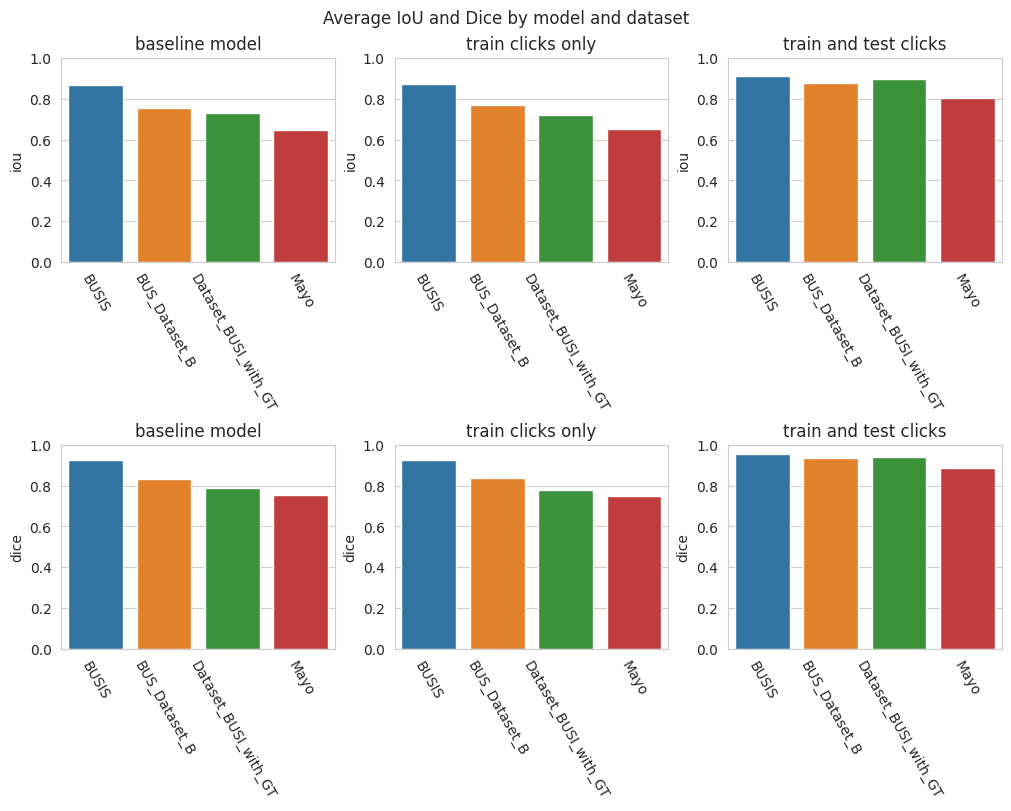

In [26]:
sns.set_style(style="whitegrid")
title = ["baseline model", "train clicks only", "train and test clicks"]
ds = {
    0: {
        "y": "iou",
        "df": dataset_mean_iou_clicks,
    },
    1: {
        "y": "dice",
        "df": dataset_mean_dice_clicks,
    },
}
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 8), constrained_layout=True)
for d in range(2):
    for r in range(3):
        ax[d, r].set_ylim([0, 1])
        sns.barplot(
            data=ds[d]["df"].query(f"test_case == '{title[r]}'"),
            hue=ds[d]["df"].query(f"test_case == '{title[r]}'")["dataset"].to_list(),
            x="dataset",
            y=ds[d]["y"],
            ax=ax[d, r],
            dodge=False,
        )
        ax[d, r].set_title(title[r])
        ax[d, r].legend().set_visible(False)
        ax[d, r].tick_params(axis="x", labelrotation=-60)
        ax[d, r].set(xlabel=None)
plt.suptitle("Average IoU and Dice by model and dataset")
plt.show()
matplotlib.rc_file_defaults()


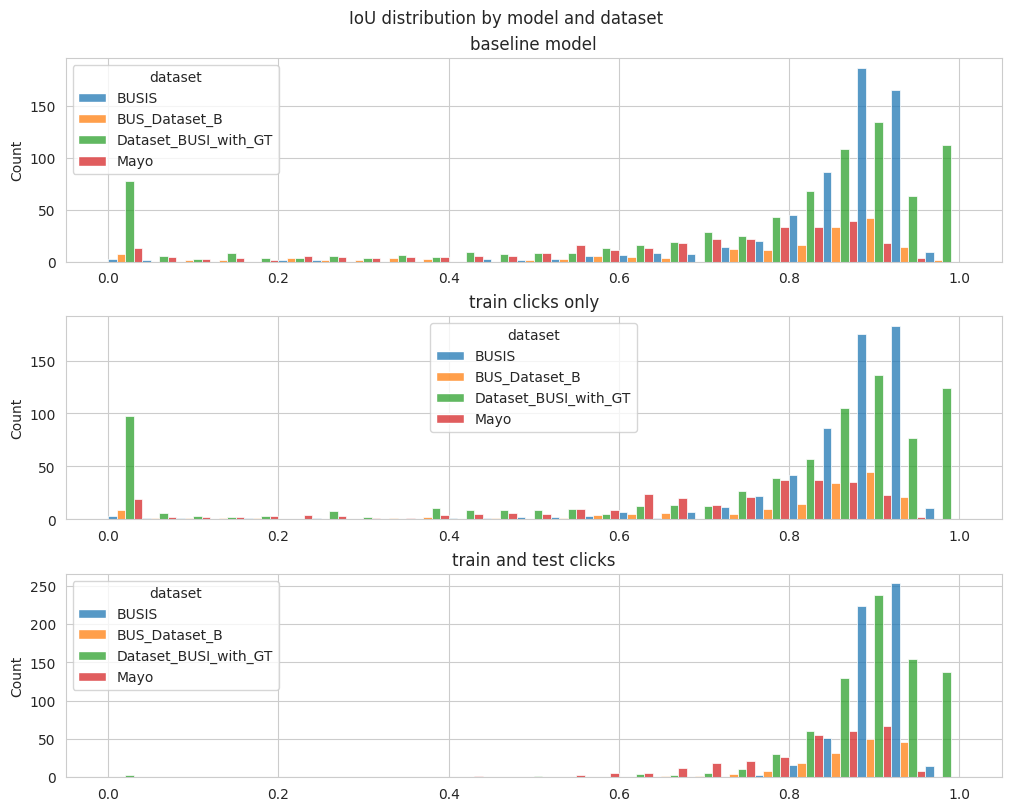

In [27]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(
    nrows=len(title), ncols=1, figsize=(10, 8), constrained_layout=True
)
for t in range(len(title)):
    sns.histplot(
        data=test_cases[title[t]]["image_perf_df"],
        x="iou",
        hue="dataset",
        ax=ax[t],
        bins=25,
        multiple="dodge",
    )
    ax[t].set_title(title[t])
    ax[t].set(xlabel=None)
fig.suptitle("IoU distribution by model and dataset")
fig.show()
matplotlib.rc_file_defaults()


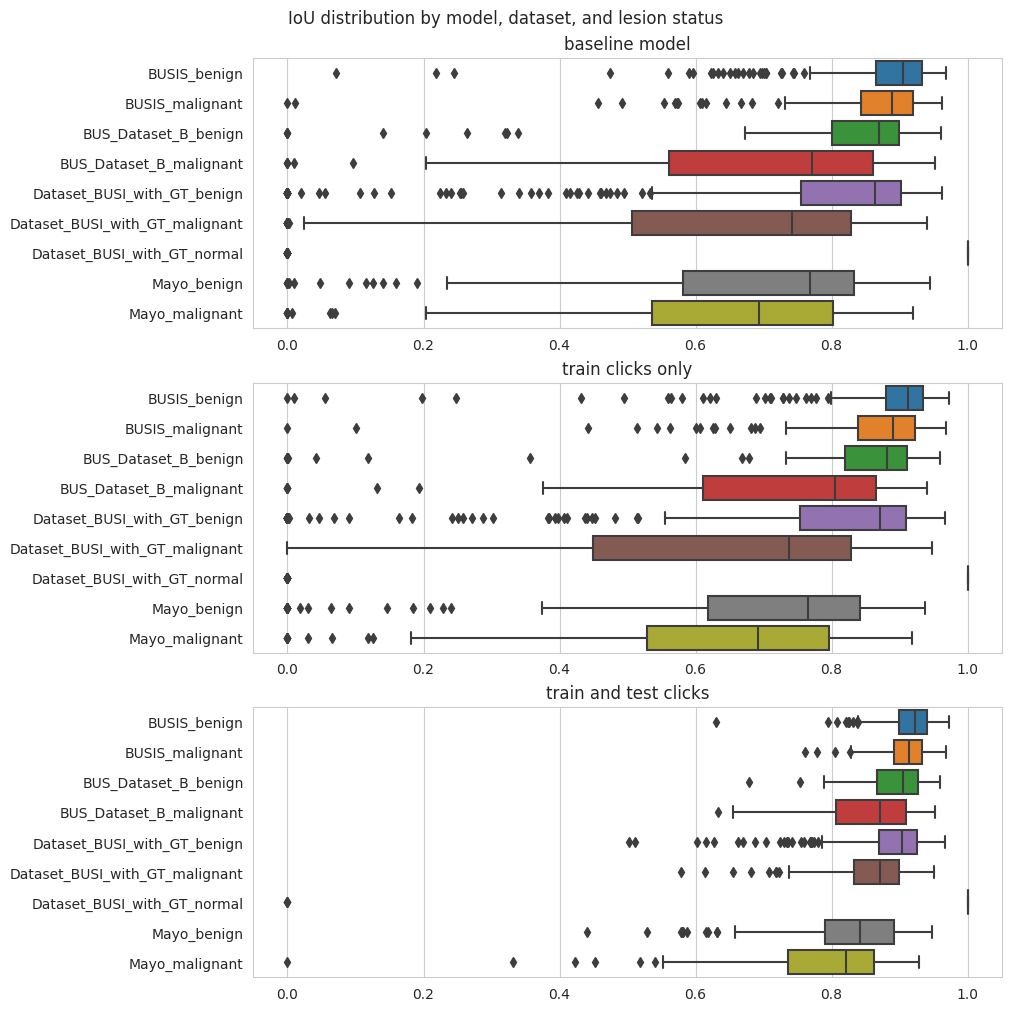

In [28]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(
    nrows=len(title), ncols=1, figsize=(10, 10), constrained_layout=True
)
for t in range(len(title)):
    sns.boxplot(
        data=test_cases[title[t]]["image_perf_df"],
        x="iou",
        y="dataset_tumor",
        orient="h",
        ax=ax[t],
    )
    ax[t].set_title(title[t])
    ax[t].set(xlabel=None, ylabel=None)
fig.suptitle("IoU distribution by model, dataset, and lesion status")
fig.show()
matplotlib.rc_file_defaults()


# Final frames

For each image, generate a big frame containing:

- the original image
- the ground-truth label (mask)
- prediction from baseline model
- prediction from click-trained model, with clicks provided during prediction
- prediction from click-trained model, without clicks provided during prediction

In [29]:
final_frames_path = "final_frames_" + model_name
ims = builtins.image_size[0]

if not os.path.exists(final_frames_path):
    os.makedirs(final_frames_path, exist_ok=True)
    for i in tqdm(range(len(ds_hf))):
        image_info = image_perf_df.loc[i, :]
        image_index = ds_hf[i]["index"]

        original_image = ds_hf[i]["original_image"]

        label_arr = np.array(ds_hf[i]["label"], dtype=np.uint8) * 255
        label_img = ImageOps.colorize(
            Image.fromarray(label_arr, mode="L"),
            black=[0, 0, 0],
            white=[255, 255, 0],
            blackpoint=0,
            whitepoint=255,
        )

        pred_baseline_arr = (
            np.array(
                Image.open(baseline_dir + "/predictions/" + str(image_index) + ".png"),
                dtype=np.uint8,
            )
            * 255
        )
        pred_baseline_img = ImageOps.colorize(
            Image.fromarray(pred_baseline_arr, mode="L"),
            black=[0, 0, 0],
            white=[255, 255, 0],
            blackpoint=0,
            whitepoint=255,
        )

        pred_train_test_click_arr = (
            np.array(
                Image.open(
                    predictions_path
                    + test_cases["train and test clicks"]["path_suffix"]
                    + "/"
                    + str(image_index)
                    + ".png"
                ),
                dtype=np.uint8,
            )
            * 255
        )
        pred_train_test_click_img = ImageOps.colorize(
            Image.fromarray(pred_train_test_click_arr, mode="L"),
            black=[0, 0, 0],
            white=[255, 255, 0],
            blackpoint=0,
            whitepoint=255,
        )

        pred_train_click_arr = (
            np.array(
                Image.open(
                    predictions_path
                    + test_cases["train clicks only"]["path_suffix"]
                    + "/"
                    + str(image_index)
                    + ".png"
                ),
                dtype=np.uint8,
            )
            * 255
        )
        pred_train_click_img = ImageOps.colorize(
            Image.fromarray(pred_train_click_arr, mode="L"),
            black=[0, 0, 0],
            white=[255, 255, 0],
            blackpoint=0,
            whitepoint=255,
        )

        img_label_merged = Image.composite(
            label_img, original_image, Image.fromarray(label_arr, mode="L")
        )
        pred_baseline_merged = Image.composite(
            pred_baseline_img,
            original_image,
            Image.fromarray(pred_baseline_arr, mode="L"),
        )
        pred_train_test_click_merged = Image.composite(
            pred_train_test_click_img,
            original_image,
            Image.fromarray(pred_train_test_click_arr, mode="L"),
        )
        pred_train_click_merged = Image.composite(
            pred_train_click_img,
            original_image,
            Image.fromarray(pred_train_click_arr, mode="L"),
        )

        oi_text = (
            "original image\ndataset: "
            + image_info["dataset"]
            + "\nlesion class: "
            + image_info["tumor"]
            + "\nimage index: "
            + str(i)
        )
        draw = ImageDraw.Draw(original_image)
        bbox = draw.multiline_textbbox((0, 0), oi_text)
        draw.rectangle(bbox, fill="black")
        draw.text((0, 0), oi_text)

        label_text = "ground truth label"
        draw = ImageDraw.Draw(img_label_merged)
        bbox = draw.multiline_textbbox((0, 0), label_text)
        draw.rectangle(bbox, fill="black")
        draw.text((0, 0), label_text)

        pred_baseline_text = "prediction from plain model\nIoU: " + str(
            round(image_info["iou"], ndigits=4)
        )
        draw = ImageDraw.Draw(pred_baseline_merged)
        bbox = draw.multiline_textbbox((0, 0), pred_baseline_text)
        draw.rectangle(bbox, fill="black")
        draw.text((0, 0), pred_baseline_text)

        pred_train_test_click_text = (
            "prediction from model trained and tested with clicks\nIoU: "
            + str(
                round(
                    test_cases["train and test clicks"]["image_perf_df"].loc[i, "iou"],
                    ndigits=4,
                )
            )
        )
        draw = ImageDraw.Draw(pred_train_test_click_merged)
        bbox = draw.multiline_textbbox((0, 0), pred_train_test_click_text)
        draw.rectangle(bbox, fill="black")
        draw.text((0, 0), pred_train_test_click_text)

        pred_train_click_text = (
            "prediction from model trained with clicks\nIoU: "
            + str(
                round(
                    test_cases["train clicks only"]["image_perf_df"].loc[i, "iou"],
                    ndigits=4,
                )
            )
        )
        draw = ImageDraw.Draw(pred_train_click_merged)
        bbox = draw.multiline_textbbox((0, 0), pred_train_click_text)
        draw.rectangle(bbox, fill="black")
        draw.text((0, 0), pred_train_click_text)

        if len(guide_clicks[i]["clicks_positive"]) > 0:
            for c in guide_clicks[i]["clicks_positive"]:
                # Pillow and Numpy disagree on the meaning of X and Y
                # we use the Numpy convention
                # so for Pillow we swap X and Y
                ImageDraw.Draw(pred_train_test_click_merged).rectangle(
                    xy=[(c[1] - 1, c[0] - 1), (c[1] + 1, c[0] + 1)],
                    outline=(0, 255, 0),
                    fill=(0, 255, 0),
                    width=1,
                )

        if len(guide_clicks[i]["clicks_negative"]) > 0:
            for c in guide_clicks[i]["clicks_negative"]:
                ImageDraw.Draw(pred_train_test_click_merged).rectangle(
                    xy=[(c[1] - 1, c[0] - 1), (c[1] + 1, c[0] + 1)],
                    outline=(255, 0, 0),
                    fill=(255, 0, 0),
                    width=1,
                )

        big_frame = Image.new(mode="RGB", size=(ims * 3, ims * 2), color=(0, 0, 0))
        big_frame.paste(original_image, box=(0, 0))
        big_frame.paste(img_label_merged, box=(ims, 0))
        big_frame.paste(pred_baseline_merged, box=(0, ims))
        big_frame.paste(pred_train_test_click_merged, box=(ims, ims))
        big_frame.paste(pred_train_click_merged, box=(ims * 2, ims))
        big_frame.save(final_frames_path + "/" + str(image_index).zfill(4) + ".png")
else:
    print(f"Folder {final_frames_path} exists. Skip.")


Folder final_frames_mit-b5 exists. Skip.


In [30]:
! bash ./notify.sh
